In [301]:
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")

from dabl import plot
import matplotlib.pyplot as plt
import matplotlib as mpl 
from mlxtend.plotting import plot_confusion_matrix, plot_decision_regions, plot_confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns 

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, fbeta_score, matthews_corrcoef, cohen_kappa_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb


In [2]:
mpl.rcParams["figure.figsize"] = (20, 6)
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["axes.labelsize"] = 13

# [Stroke Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv)

[Stroke Disease Detection and Prediction Using Robust Learning Approaches](https://www.hindawi.com/journals/jhe/2021/7633381/)

In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# EDA

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.drop("id", axis=1, inplace=True)

In [6]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
df.describe(include="O")

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [9]:
print(f"""
gender: {', '.join(df.gender.unique())}
ever_married: {', '.join(df.ever_married.unique())}
work_type: {', '.join(df.work_type.unique())}
Residence_type: {', '.join(df.Residence_type.unique())}
smoking_status: {', '.join(df.smoking_status.unique())}
""")


gender: Male, Female, Other
ever_married: Yes, No
work_type: Private, Self-employed, Govt_job, children, Never_worked
Residence_type: Urban, Rural
smoking_status: formerly smoked, never smoked, smokes, Unknown



In [10]:
print(f"Numero de observações {len(df)}\nNumero de atributos {df.shape[-1]}")

Numero de observações 5110
Numero de atributos 11


<AxesSubplot:title={'center':'Percentual de Valores Faltantes em cada Atributo'}>

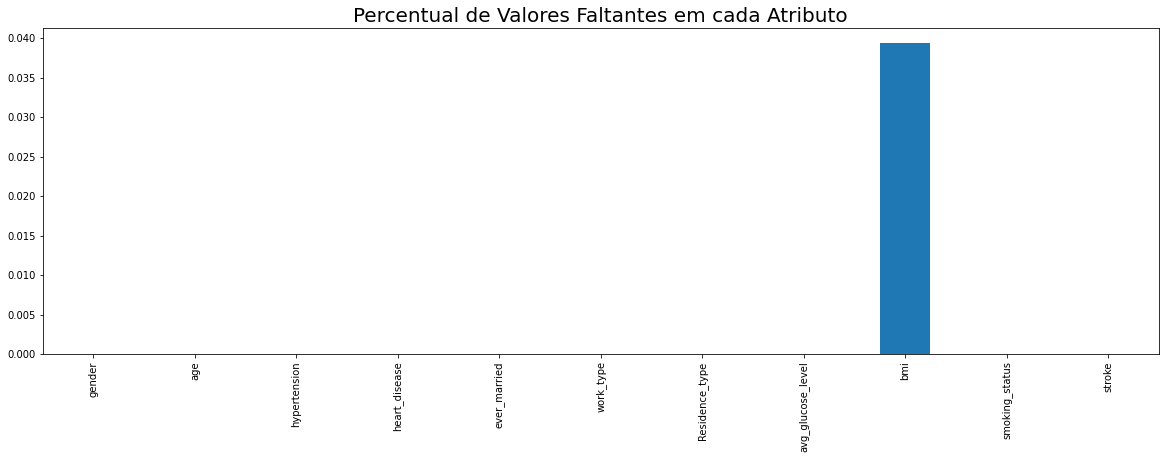

In [11]:
df.isna().mean().plot(kind="bar", title="Percentual de Valores Faltantes em cada Atributo")

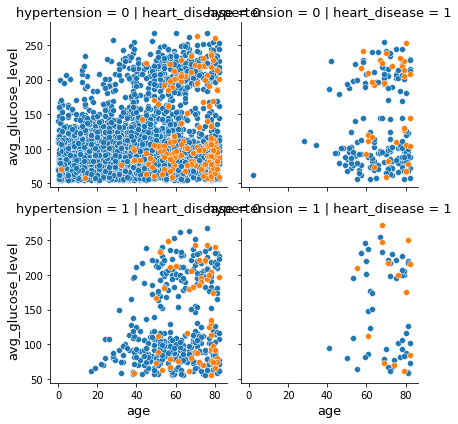

In [22]:
g = sns.FacetGrid(data=df, row="hypertension", col="heart_disease", hue="stroke")
g.map_dataframe(sns.scatterplot, x="age", y="avg_glucose_level")
plt.tight_layout()

In [13]:
fig = px.parallel_coordinates(df, color='stroke', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2)
fig.show()

In [14]:
fig = px.parallel_categories(df, color='stroke')
fig.show()

Target looks like classification
Linear Discriminant Analysis training set score: 0.500


[[<Figure size 648x648 with 12 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 1440x432 with 1 Axes>],
 None]

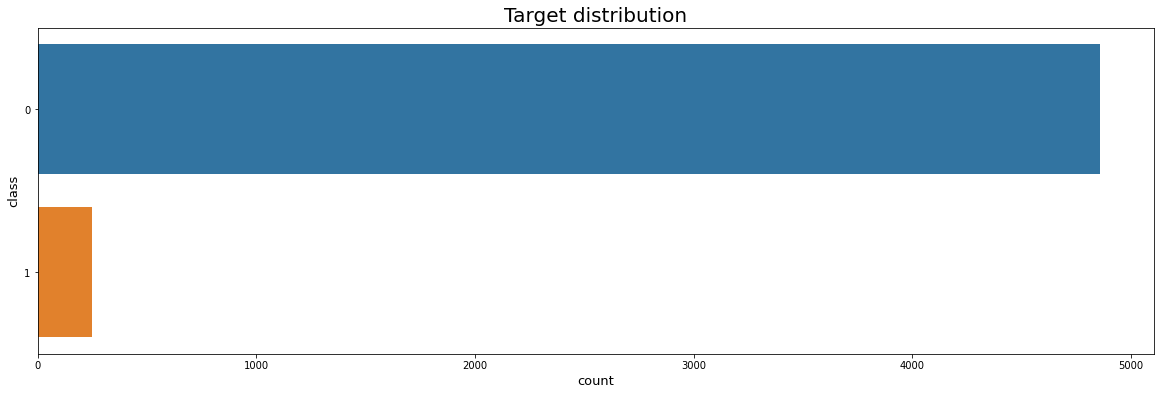

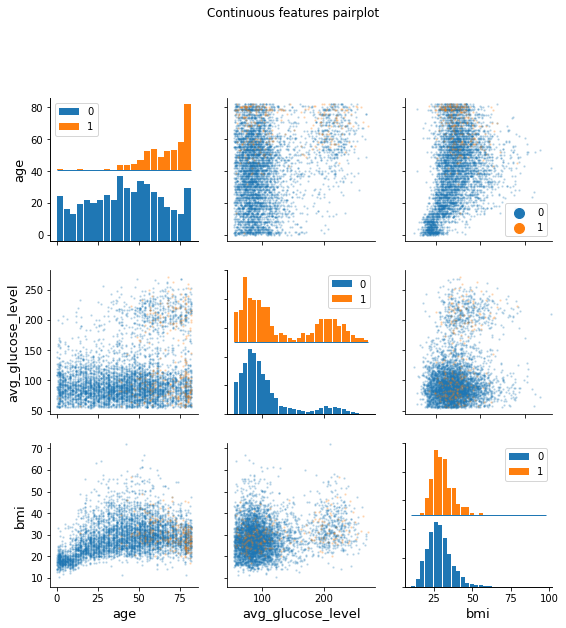

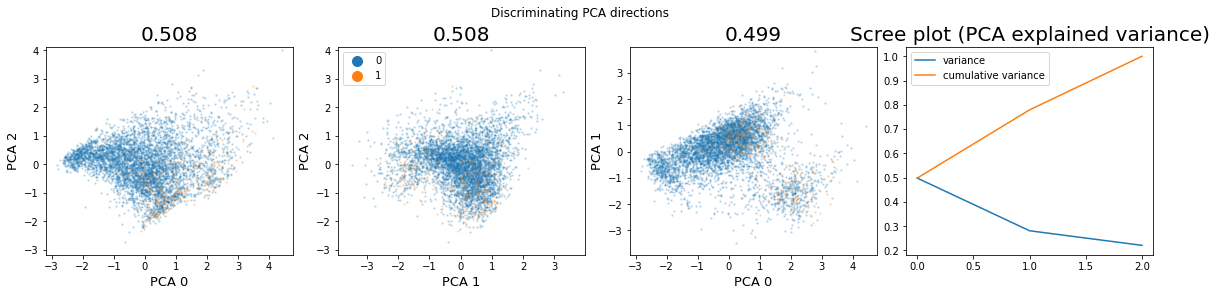

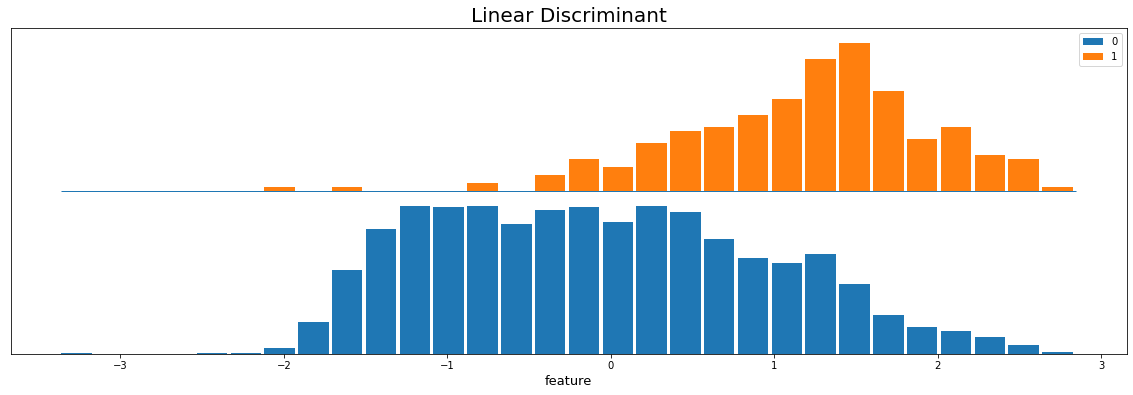

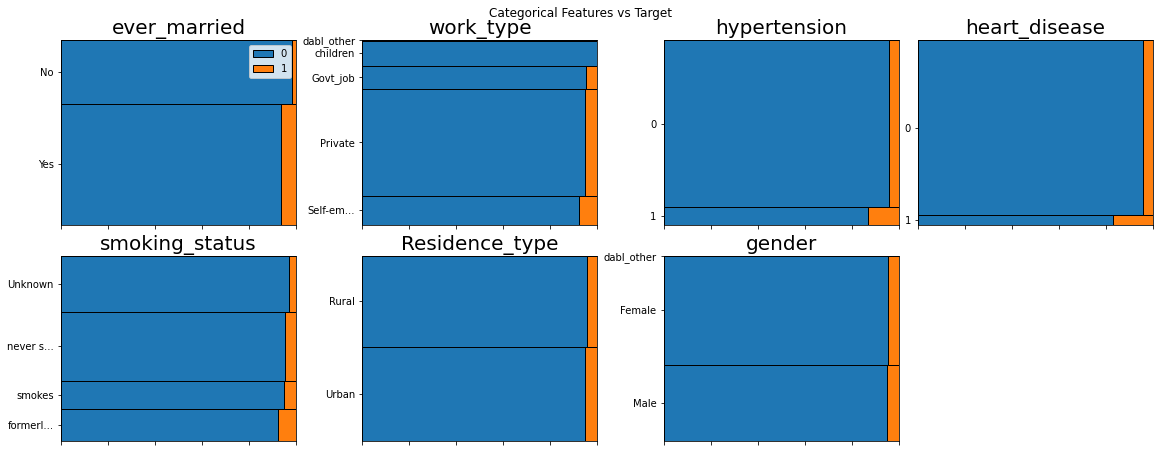

In [15]:
plot(df, y="stroke")

In [24]:
OneHotEncoder()

,Male,Other
0,1,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
5105,0,0
5106,0,0
5107,0,0
5108,1,0


<AxesSubplot:>

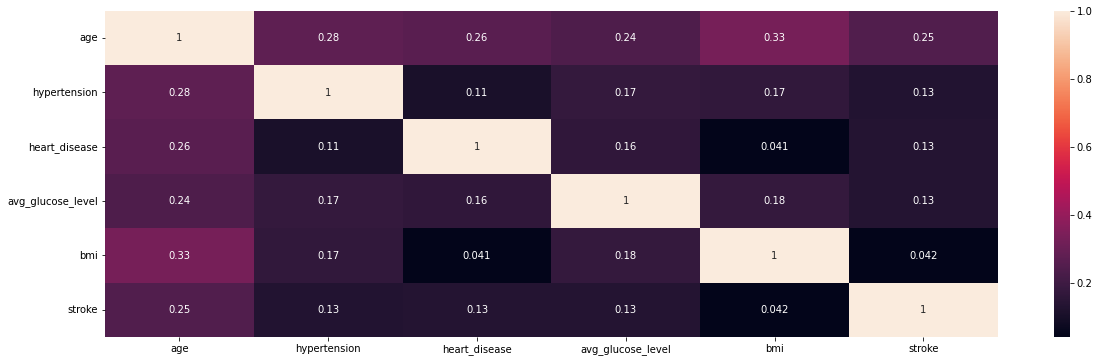

In [16]:
sns.heatmap(df.corr(), annot=True)

# Model Selection

In [33]:
X = df.loc[:, ~df.columns.str.contains("stroke")].copy()
y = df["stroke"].copy()

In [46]:
X.describe(include="O").columns.tolist()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [49]:
cat_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
num_features = ["age", "avg_glucose_level", "bmi"]

## Creating Pipeline

In [281]:
cat_transformer = OneHotEncoder(drop="if_binary")
num_transformer = Pipeline([("imputer", KNNImputer()), ("scaler", MinMaxScaler())])

preprocessing = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features), 
        ("num", num_transformer, num_features)
    ]
)

clf = Pipeline(
    steps=[
        ("preprocessing", preprocessing),
        ("resampling", SMOTE()),
        ("model", SVC())
    ]
)
clf2 = Pipeline(
    steps=[
        ("preprocessing", preprocessing),
        ("resampling", SMOTE()),
        ("model", LogisticRegression())
    ]
)

In [282]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, fbeta_score

In [283]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [294]:
param_grid = {"model__C": [1.0, 2.0, 5.0, 10.0]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(clf, param_grid, scoring=ftwo_scorer, cv=inner_cv, **{})
grid2 = GridSearchCV(clf2, {"model__penalty": ["l1", "l2"]}, scoring=ftwo_scorer, cv=inner_cv, **{})
nested_score = cross_validate(grid, X=X, y=y, cv=outer_cv, scoring={"AUC": "roc_auc", "F2": ftwo_scorer, "acc": "accuracy"}, return_train_score=True)
nested_score2 = cross_validate(grid2, X=X, y=y, cv=outer_cv, scoring={"AUC": "roc_auc", "F2": ftwo_scorer, "acc": "accuracy"}, return_train_score=True)

In [295]:
k1 = pd.DataFrame(nested_score)
k2 = pd.DataFrame(nested_score2)
k1["model"] = "SVM"
k2["model"] = "Logistic"
k = pd.concat([k1,k2]).reset_index().rename({"index": "fold"}, axis=1)
k_ = k.groupby("model", as_index=False).mean()
k_

,model,fold,fit_time,score_time,test_AUC,train_AUC,test_F2,train_F2,test_acc,train_acc
0,Logistic,2.0,1.219471,0.000399,NaN,0.842942,NaN,0.401110,NaN,0.739726
1,SVM,2.0,19.100418,0.532797,0.757064,0.887574,0.309225,0.493016,0.788894,0.814139


In [296]:
k

,fold,fit_time,score_time,test_AUC,train_AUC,test_F2,train_F2,test_acc,train_acc,model
0,0,19.490981,0.685322,0.748642,0.886553,0.277778,0.487013,0.786693,0.812378,SVM
1,1,18.911843,0.683258,0.743477,0.889363,0.294118,0.517560,0.779843,0.831213,SVM
2,2,19.640828,0.001987,NaN,0.884951,NaN,0.476738,NaN,0.801370,SVM
3,3,18.897696,0.675510,0.786214,0.887402,0.328467,0.487589,0.797456,0.812867,SVM
4,4,18.560742,0.617907,0.749921,0.889600,0.336538,0.496183,0.791585,0.812867,SVM
5,0,1.198811,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,Logistic
6,1,1.160008,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,Logistic
7,2,1.268552,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,Logistic
8,3,1.174955,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,Logistic
9,4,1.295028,0.001995,NaN,0.842942,NaN,0.401110,NaN,0.739726,Logistic


In [297]:
m = k.melt(id_vars=["model", "fold"], value_vars=["test_roc_auc", "test_accuracy"], var_name="score_type", value_name="score_value")

KeyError: "The following 'value_vars' are not present in the DataFrame: ['test_accuracy', 'test_roc_auc']"

In [308]:
class Classifier:
    """Tune and selects classifier models based on a nested cross validation 
    from models that follow the same structure from sklearn. 

    Parameters
    ----------
    models : dict[str, tuple]
        A dictionary containg the classifier name and a tuple with the model
        object and the parameters' space that will be used in the tunnig part.
            Example:
                {
                    "Logistic": (
                        LogisticRegression(), 
                        {"Logistic__penalty": ["l1", "l2"]}
                    ),
                    "SVM": (
                        SVC(),
                        {"SVM__C": [1, 5, 10]}
                    )
                }
    preprocessing : ColumnTransformer
        The preprocssing step that will be used before fitting and 
        predictions.
    resampling_step : tuple, optional
        A tuple that contains the name for the resampling step and a resampler
        object from imblearn, by default ("resampling", SMOTE())
    inner_cv : _type_, optional
        _description_, by default StratifiedKFold(n_splits=5, shuffle=True, random_state=47)
    outer_cv : _type_, optional
        _description_, by default StratifiedKFold(n_splits=10, shuffle=True, random_state=47)
    scoring : dict[str, any], optional
        _description_, by default None
    optimize : str, optional
        _description_, by default None
    searcher : _type_, optional
        _description_, by default GridSearchCV
    kwargs_searcher : dict, optional
        _description_, by default None
    """
    def __init__(
        self, 
        models: dict[str, tuple],
        preprocessing: ColumnTransformer, 
        resampling_step: tuple=("resampling", SMOTE()), 
        inner_cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=47),
        outer_cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=47),
        scoring: dict[str, any]=None,
        optimize: str=None,
        searcher=GridSearchCV,
        kwargs_searcher: dict=None
    ) -> None:
        self.models = models
        self.preprocessing = preprocessing
        self.resampling_step = resampling_step
        self.scoring = scoring
        self.score_names = [key for key in self.scoring.keys()]
        self.optimize = optimize
        self.searcher = searcher
        self.kwargs_searcher = kwargs_searcher if kwargs_searcher else {}
        self.inner_cv = inner_cv
        self.outer_cv = outer_cv
    
    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> None:
        results = []
        for model_name, (clf, search_space) in tqdm(self.models.items()):
            start = time.time()
            print(f"Starting {model_name}...")
            search = self._create_search((model_name, clf), search_space)
            result = self._nested_cross_validation(search, X, y)
            result_df = pd.DataFrame(result)
            result_df["model"] = model_name
            results.append(result_df)
            end = time.time()
            time_span = end-start
            print(f"Finished {model_name} in {time_span:.2f}s")
            print("-"*50)

        self.raw_results = pd.concat(results).reset_index().rename({"index": "fold"}, axis=1)

    def plot_fold_results(self) -> None:
        data = self.raw_results.melt(
            id_vars=["model", "fold"], 
            value_vars=[f"test_{score}" for score in self.score_names], 
            var_name="score_type", 
            value_name="score_value"
        )
        data["score_type"] = data["score_type"].apply(lambda x: x.split("test_")[-1])
        fig = px.line(data, x="fold", y="score_value", facet_col="score_type", color="model")
        fig.show()

    def plot_results(self) -> None:
        data = self.raw_results.melt(
            id_vars=["model", "fold"], 
            value_vars=[f"test_{score}" for score in self.score_names], 
            var_name="score_type", 
            value_name="score_value"
        )
        data["score_type"] = data["score_type"].apply(lambda x: x.split("test_")[-1])
        fig = px.box(data, x="model", y="score_value", facet_row="score_type", color='model')
        fig.show()

    @property
    def get_results(self) -> pd.DataFrame:
        if not hasattr(self, "raw_results"):
            AttributeError("There's not raw_results attribute! Try fitting the Classifier first")
        return self.raw_results.groupby()


    def _create_search(self, estimator: tuple, search_space: dict):
        """_summary_

        Parameters
        ----------
        estimator : tuple
            _description_
        search_space : dict
            _description_

        Returns
        -------
        
            _description_
        """
        name, clf = estimator
        pipe = Pipeline(
            steps=[
                ("preprocessing", self.preprocessing),
                self.resampling_step,
                (name, clf)
            ]
        )
        
        return self.searcher(estimator=pipe, param_grid=search_space, scoring=self.optimize, cv=self.inner_cv, **self.kwargs_searcher)

    def _nested_cross_validation(self, search, X: pd.DataFrame, y: pd.DataFrame) -> dict:
        """_summary_

        Parameters
        ----------
        search : 
            _description_
        X : pd.DataFrame
            _description_
        y : pd.DataFrame
            _description_

        Returns
        -------
        np.array
            _description_
        """
        return cross_validate(search, X=X, y=y, cv=self.outer_cv, scoring=self.scoring)

In [309]:
models = {
    "SVM": (
        SVC(random_state=47),
        {"SVM__C": [0.01, 0.1, 1, 5, 10], "SVM__kernel": ["linear", "poly", "rbf"]}
    ),
    "Logistic": (
        LogisticRegression(random_state=47),
        {"Logistic__penalty": ["l1", "l2", "elasticnet"], "Logistic__C": [0.01, 0.1, 1, 5, 10]}
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=47),
        {
            "DecisionTree__max_depth": [None, 5, 10, 20, 50], 
            "DecisionTree__min_samples_split": [2, 10, 20, 30, 50], 
            "DecisionTree__cpp_alpha": [0, 0.005, 0.010, 0.02, 0.05]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=47),
        {
            "RandomForest__max_depth": [None, 5, 10, 20, 50], 
            "RandomForest__min_samples_split": [2, 10, 20, 30, 50], 
            "RandomForest__cpp_alpha": [0, 0.005, 0.010, 0.02, 0.05]
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=47),
        {"AdaBoost__leraning_rate": [0.1, 0.5, 1.0, 5.0], "AdaBoost__n_estimators": [10, 20, 30, 50, 100]}
    ),
    "GradientBoost": (
        GradientBoostingClassifier(random_state=47),
        {
            "GradientBoost__n_estimators": [20, 50, 100, 150, 200],
            "GradientBoost__learning_rate": [0.1, 0.5, 1, 5],
            "GradientBoost__loss": ["deviance", "exponential"],
            "GradientBoost__max_depth": [2, 3, 4, 5],
            "GradientBoost__min_samples_split": [2, 10, 20, 30, 50]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "KNN__n_neighbors": [3, 5, 10, 15, 20, 30],
            "KNN__weights": ["uniform", "distance"],
            "KNN__p": [1, 2]
        }
    ), 
}

scoring = {
    "Accuracy": "accuracy",
    "Balanced Accuracy": "balanced_accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "AUC": "roc_auc",
    "F1-Micro": "f1_micro",
    "F1-Weighted": "f1_weighted",
    "F2-Micro": make_scorer(fbeta_score, beta=2, average="micro"), 
    "F2-Weighted": make_scorer(fbeta_score, beta=2, average="weighted"), 
    "MCC": make_scorer(matthews_corrcoef)
}

In [310]:
clf = Classifier(models=models, preprocessing=preprocessing, scoring=scoring, optimize="recall")
clf.fit(X, y)

  0%|          | 0/7 [00:00<?, ?it/s]

Starting SVM...


In [245]:
import pickle
with open("Num_KNNImputer_MinMaxScaler_Cat_OneHotEncoding_Resampling_SMOTE.pkl") as f:
    pickle.dump(clf, f)

,fold,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_roc_auc,test_f1_micro,test_f1_weighted,test_recall,test_precision,model
0,0,0.001993,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SVM
1,1,0.001994,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SVM
2,2,0.001668,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SVM
3,3,0.001992,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SVM
4,4,0.001980,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SVM
...,...,...,...,...,...,...,...,...,...,...,...
65,5,0.002001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KNN
66,6,0.000997,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KNN
67,7,0.000996,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KNN
68,8,0.000996,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KNN
